In [8]:
import numpy as np
import os
# PIL pillow to process images
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [25]:
# load datasets from web

# dataset structure
#
# flowers_photos/
#      daisy/
#      dandelion/
#      roses/
#      sunflowers/
#      tulips/
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    fname='flowers_photos',
    untar=True
)


In [40]:
flowers_path = pathlib.Path(data_dir)
flowers = list(flowers_path.glob('roses/*'))

641

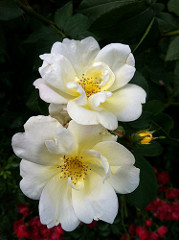

In [41]:
PIL.Image.open(flowers[0])

## Dataset

In [51]:
# It's good practice to use a validation split when developing your model. 
# You will use 80% of the images for training and 20% for validation.

batch_size = 32
image_height = 180
image_width = 180

# classify images based on the name of the subdirectories
# training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    flowers_path,
    validation_split=0.2, # 20% for testing
    subset='training', # important!
    seed=123, # any random number
    image_size=(image_height, image_width),
    batch_size=batch_size
)

# validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    flowers_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [53]:
class_names = train_ds.class_names

## Visualize data

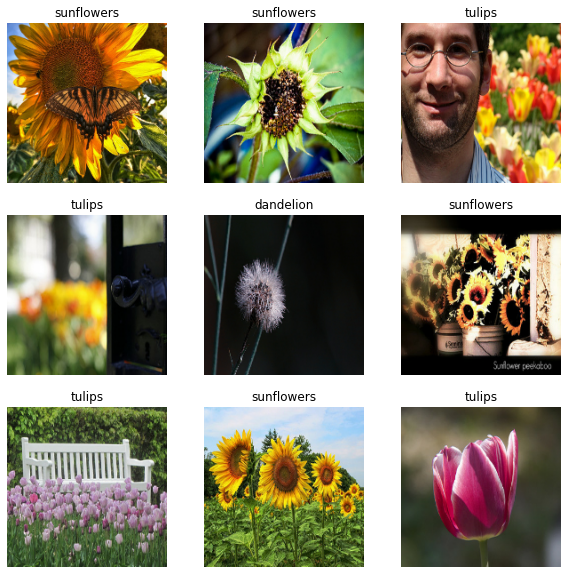

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# train_ds contains 2 parts
# 1. training data
# 2. test data

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1) # print images in a grid of 3x3
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
    

## Standarize data

In [49]:
# The RGB channel values are in the [0, 255] range. 
# This is not ideal for a neural network; in general you should seek to make your input values small. 
# Here, you will standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.
# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# see "Train model section"

AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

## Train model

In [54]:
num_classes = len(train_ds.class_names)

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # standarize values
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
92/92 [==============================] - 22s 123ms/step - loss: 1.3056 - accuracy: 0.4322 - val_loss: 1.1036 - val_accuracy: 0.5736
Epoch 2/5
92/92 [==============================] - 8s 82ms/step - loss: 1.0222 - accuracy: 0.5926 - val_loss: 0.9871 - val_accuracy: 0.6213
Epoch 3/5
92/92 [==============================] - 8s 84ms/step - loss: 0.8733 - accuracy: 0.6652 - val_loss: 0.9534 - val_accuracy: 0.5954
Epoch 4/5
92/92 [==============================] - 12s 133ms/step - loss: 0.7373 - accuracy: 0.7163 - val_loss: 0.8978 - val_accuracy: 0.6471
Epoch 5/5
92/92 [==============================] - 12s 112ms/step - loss: 0.5596 - accuracy: 0.7902 - val_loss: 0.9950 - val_accuracy: 0.6362


In [59]:
## Evaluation
val_ds.take(1)

<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [58]:
val_images, val_labels = val_ds.take(1)
model.evaluate(val_images, val_labels, verbose=2)

ValueError: not enough values to unpack (expected 2, got 1)

In [64]:
val = val_ds.take(1)
list(val)

[(<tf.Tensor: shape=(32, 180, 180, 3), dtype=float32, numpy=
  array([[[[6.80888901e+01, 1.11866669e+02, 1.80477768e+02],
           [6.94222260e+01, 1.14422226e+02, 1.82422211e+02],
           [7.19493790e+01, 1.16949379e+02, 1.84949387e+02],
           ...,
           [7.49271088e+01, 1.22927109e+02, 1.96927109e+02],
           [7.05110931e+01, 1.18511093e+02, 1.94177780e+02],
           [6.98234634e+01, 1.17266670e+02, 1.94380249e+02]],
  
          [[6.93703690e+01, 1.12940742e+02, 1.81655548e+02],
           [7.10444489e+01, 1.15600006e+02, 1.83822220e+02],
           [7.25185165e+01, 1.17518517e+02, 1.85518524e+02],
           ...,
           [7.61555252e+01, 1.24155525e+02, 1.97651825e+02],
           [7.28222046e+01, 1.20822205e+02, 1.96488892e+02],
           [7.25333328e+01, 1.20533333e+02, 1.96533340e+02]],
  
          [[7.08333282e+01, 1.13833328e+02, 1.82833328e+02],
           [7.35185165e+01, 1.16703705e+02, 1.85611115e+02],
           [7.39938278e+01, 1.18944443e+02, 1